<a href="https://colab.research.google.com/github/Sevnhutsjr/ST311_Group11_Project/blob/main/images_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for Loading Images and Exploring the Data

In [1]:
## Imports
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision


Loading the Data

In [2]:
# Download latest version
path = kagglehub.dataset_download("ananthu017/emotion-detection-fer")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/emotion-detection-fer


In [3]:
import os

base_path = "/kaggle/input/emotion-detection-fer"
for root, dirs, files in os.walk(base_path):
    print(root)


/kaggle/input/emotion-detection-fer
/kaggle/input/emotion-detection-fer/test
/kaggle/input/emotion-detection-fer/test/fearful
/kaggle/input/emotion-detection-fer/test/disgusted
/kaggle/input/emotion-detection-fer/test/angry
/kaggle/input/emotion-detection-fer/test/neutral
/kaggle/input/emotion-detection-fer/test/sad
/kaggle/input/emotion-detection-fer/test/surprised
/kaggle/input/emotion-detection-fer/test/happy
/kaggle/input/emotion-detection-fer/train
/kaggle/input/emotion-detection-fer/train/fearful
/kaggle/input/emotion-detection-fer/train/disgusted
/kaggle/input/emotion-detection-fer/train/angry
/kaggle/input/emotion-detection-fer/train/neutral
/kaggle/input/emotion-detection-fer/train/sad
/kaggle/input/emotion-detection-fer/train/surprised
/kaggle/input/emotion-detection-fer/train/happy


Using device: cpu
Epoch 1/10, Loss: 1.6210, Test Accuracy: 0.4560
Epoch 2/10, Loss: 1.3759, Test Accuracy: 0.5127
Epoch 3/10, Loss: 1.2455, Test Accuracy: 0.5439
Epoch 4/10, Loss: 1.1548, Test Accuracy: 0.5382
Epoch 5/10, Loss: 1.0677, Test Accuracy: 0.5577
Epoch 6/10, Loss: 0.9933, Test Accuracy: 0.5741
Epoch 7/10, Loss: 0.9110, Test Accuracy: 0.5709
Epoch 8/10, Loss: 0.8314, Test Accuracy: 0.5755
Epoch 9/10, Loss: 0.7635, Test Accuracy: 0.5811
Epoch 10/10, Loss: 0.6798, Test Accuracy: 0.5770


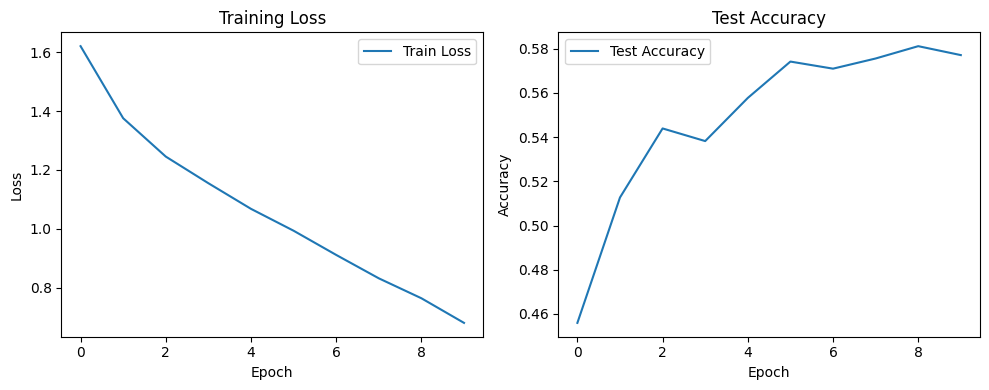

Final Test Accuracy: 57.70%


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

root_path = "/kaggle/input/emotion-detection-fer/images"
train_dir = "/kaggle/input/emotion-detection-fer/train"
test_dir = "/kaggle/input/emotion-detection-fer/test"


# Image transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Simple CNN model
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 7)  # 7 emotion classes
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x

model = EmotionCNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train(model, loader):
    model.train()
    running_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

# Evaluation loop
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


train_losses = []
test_accuracies = []

epochs = 10
for epoch in range(epochs):
    loss = train(model, train_loader)
    acc = evaluate(model, test_loader)
    train_losses.append(loss)
    test_accuracies.append(acc)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Final test accuracy
print(f"Final Test Accuracy: {test_accuracies[-1]*100:.2f}%")


IGNORE BELOW

Looking at what the data looks like

In [ ]:
# # Step 2: Set paths to train and test folders
# train_path = os.path.join(path, "train")
# test_path = os.path.join(path, "test")

# # Step 3: Define transforms
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),     # Resize images to 128x128
#     transforms.ToTensor(),             # Convert to tensor
#     transforms.Normalize([0.5], [0.5]) # Normalize (grayscale images)
# ])

# # Step 4: Load datasets
# train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
# test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# # Step 5: Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# # Step 6: Print class labels
# print("Emotion classes:", train_dataset.classes)

Emotion classes: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


# Looking at the Images
*How the code works*
- Grabs the first batch of images and labels from your training set.
- Shows the first 8 images in a grid.
- Converts the normalized images back to viewable format.
- Displays labels as a title.

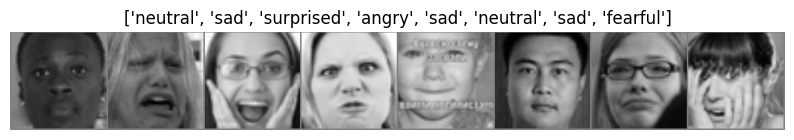

In [ ]:
# # Function to show images
# def imshow(img, title):
#     img = img / 2 + 0.5  # unnormalize (because you normalized to [-1, 1])
#     npimg = img.numpy()
#     plt.figure(figsize=(10, 5))
#     plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
#     plt.title(title)
#     plt.axis('off')
#     plt.show()

# # Get a batch of training data
# dataiter = iter(train_loader)
# images, labels = next(dataiter)

# imshow(torchvision.utils.make_grid(images[:8]), title=[train_dataset.classes[label] for label in labels[:8]])


Training a CNN

In [ ]:
# Imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


In [ ]:
train_dir = "/kaggle/input/emotion-detection-fer/train"
test_dir = "/kaggle/input/emotion-detection-fer/test"

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Defining the CNN Model

In [ ]:

class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 7)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x

model = EmotionCNN().to(device)


Optimizers

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Training and Eval Functions

In [ ]:
# Training function
def train(model, loader):
    model.train()
    running_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

# Evaluation function
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


Plotting Training Progress

In [ ]:
# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


Final Acccuracy

In [ ]:
# Final test accuracy
print(f"Final Test Accuracy: {test_accuracies[-1]*100:.2f}%")


New Model

Looking at Data

Doing some EDA to check the data

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Base directory
base_dir = "/kaggle/input/emotion-detection-fer"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Check paths exist
print("Checking directories...")
for path in [base_dir, train_dir, test_dir]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"❌ Path does not exist: {path}")
    else:
        print(f"✅ Found: {path}")

# Get emotion class names
class_names = sorted(os.listdir(train_dir))
print("Classes:", class_names)


Checking directories...
✅ Found: /kaggle/input/emotion-detection-fer
✅ Found: /kaggle/input/emotion-detection-fer/train
✅ Found: /kaggle/input/emotion-detection-fer/test
Classes: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


Class Distribution in Train and Test Sets

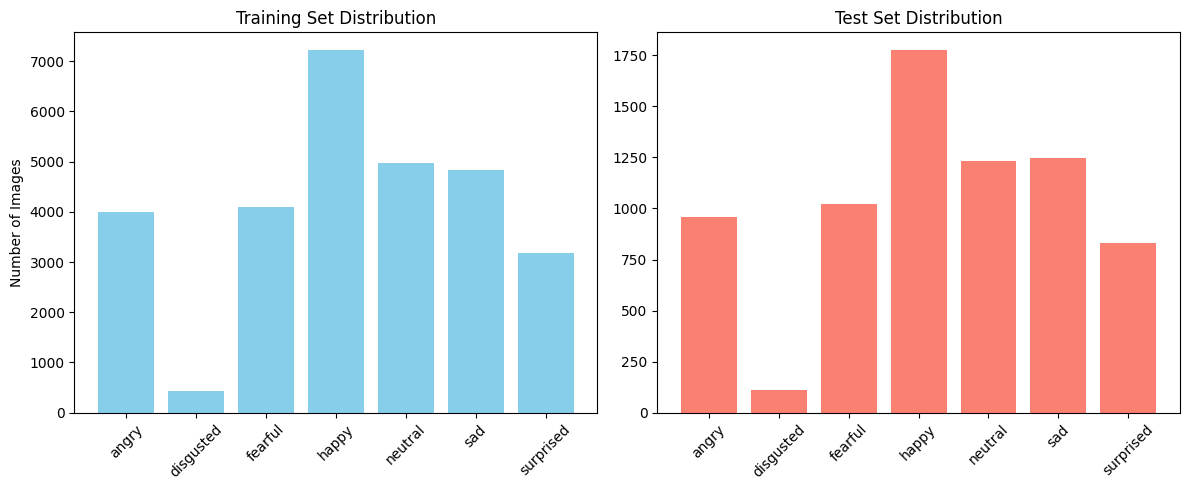

In [14]:
# Count samples per class
train_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in class_names}
test_counts = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in class_names}

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(train_counts.keys(), train_counts.values(), color='skyblue')
axes[0].set_title('Training Set Distribution')
axes[0].set_ylabel('Number of Images')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(test_counts.keys(), test_counts.values(), color='salmon')
axes[1].set_title('Test Set Distribution')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Sample Image from Each Emotion Class

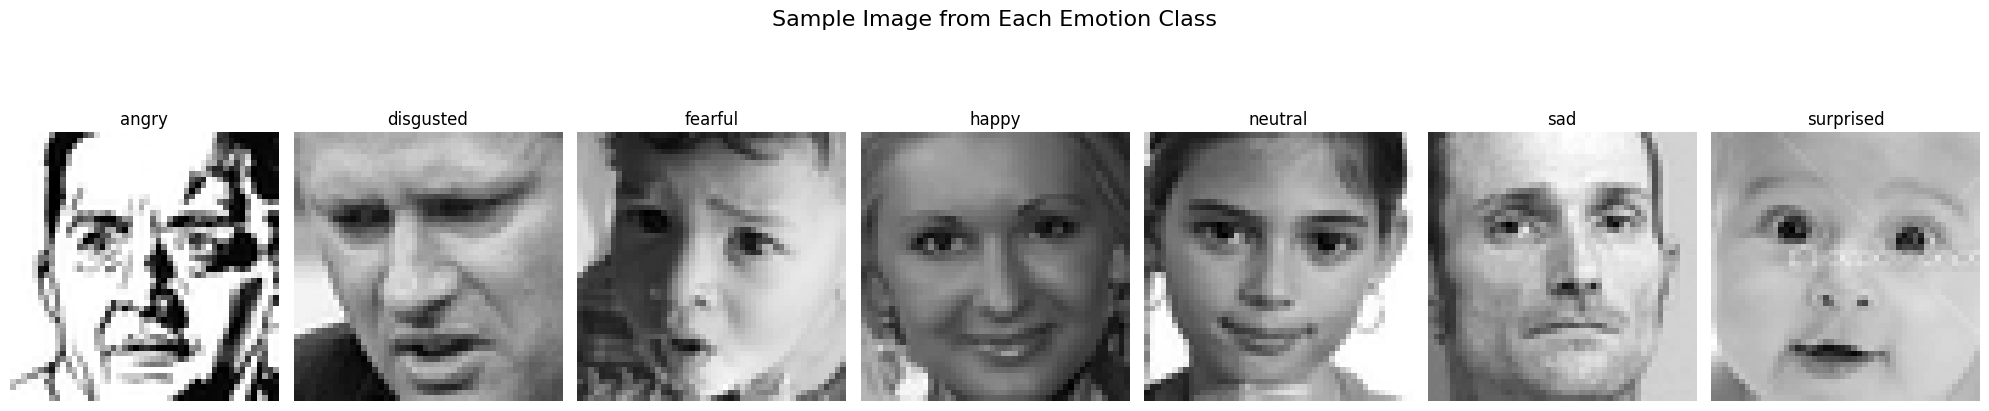

In [15]:
# Show one image per emotion
fig, axes = plt.subplots(1, len(class_names), figsize=(20, 5))
for idx, cls in enumerate(class_names):
    img_path = os.path.join(train_dir, cls, os.listdir(os.path.join(train_dir, cls))[0])
    img = Image.open(img_path)
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(cls)
    axes[idx].axis('off')

plt.suptitle("Sample Image from Each Emotion Class", fontsize=16)
plt.tight_layout()
plt.show()


Image Size Consistency Check

In [16]:
# Check for consistent image sizes
img_sizes = []
for cls in class_names:
    cls_path = os.path.join(train_dir, cls)
    for img_file in os.listdir(cls_path)[:100]:  # sample 100 per class
        img_path = os.path.join(cls_path, img_file)
        img = Image.open(img_path)
        img_sizes.append(img.size)

img_sizes = np.array(img_sizes)
unique_sizes, counts = np.unique(img_sizes, axis=0, return_counts=True)

print("\n✅ Image Size Summary:")
for sz, ct in zip(unique_sizes, counts):
    print(f"  Size {tuple(sz)} → {ct} images")



✅ Image Size Summary:
  Size (np.int64(48), np.int64(48)) → 700 images


Pixel Intensity Histogram per Class

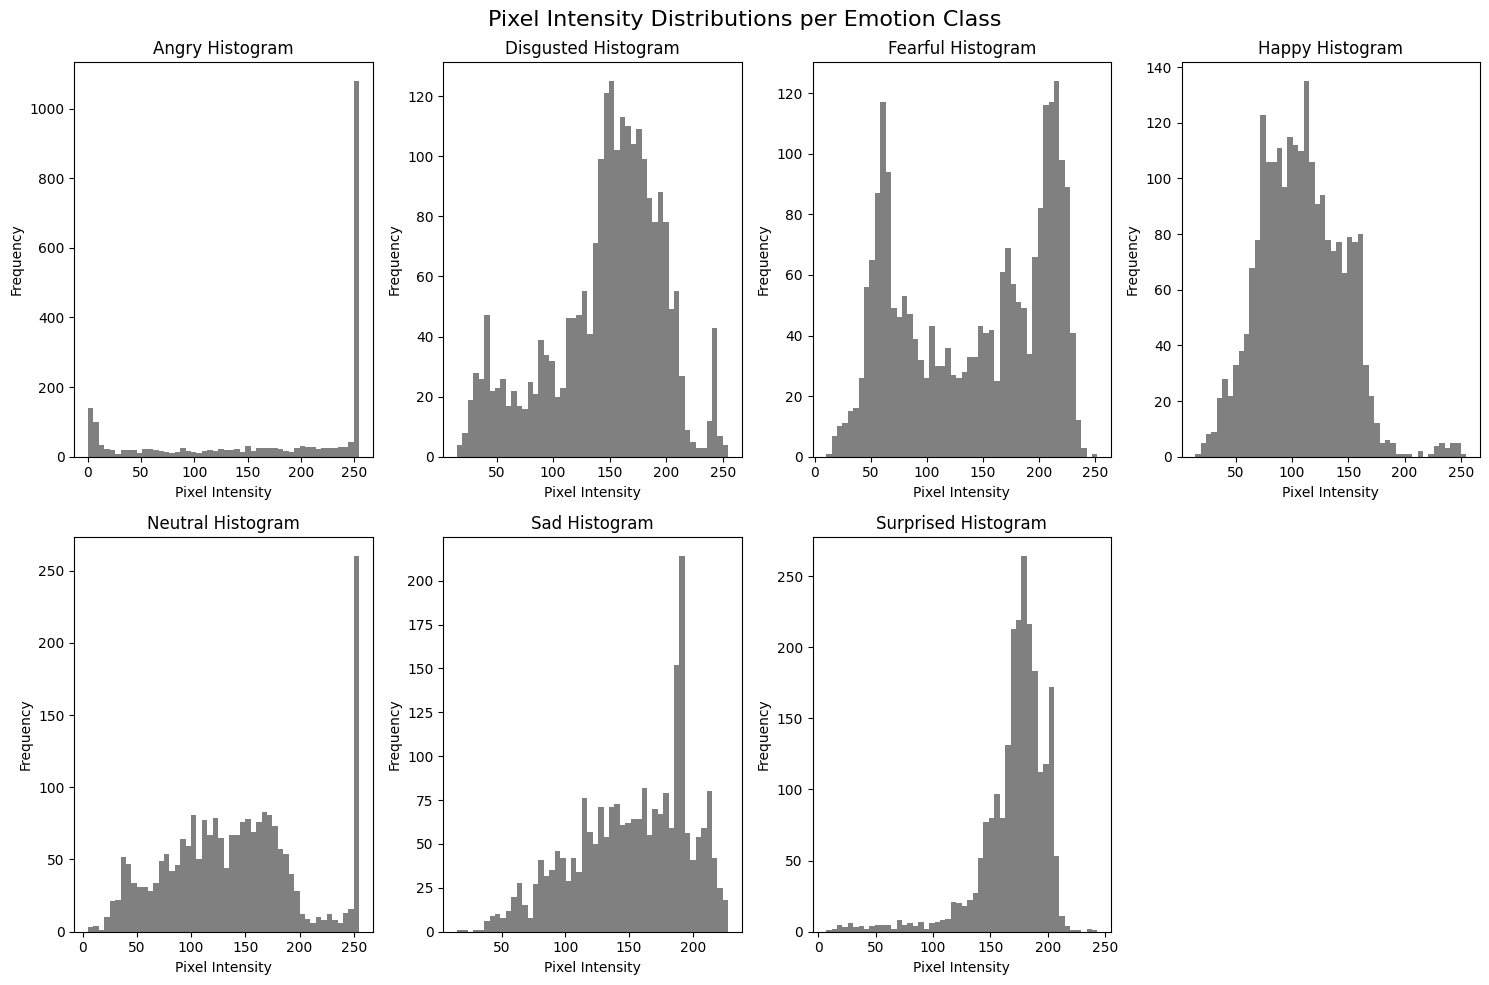

In [17]:
plt.figure(figsize=(15, 10))
for i, cls in enumerate(class_names):
    class_path = os.path.join(train_dir, cls)
    sample_img_path = os.path.join(class_path, os.listdir(class_path)[0])
    sample_img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(2, 4, i + 1)
    plt.hist(sample_img.ravel(), bins=50, color='gray')
    plt.title(f"{cls.capitalize()} Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

plt.suptitle("Pixel Intensity Distributions per Emotion Class", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# Model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

# ✅ Dataset paths
train_dir = "/kaggle/input/emotion-detection-fer/train"
test_dir = "/kaggle/input/emotion-detection-fer/test"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Transform
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ✅ Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)

# ✅ CNN Model
class EmotionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# ✅ Model setup
model = EmotionCNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# ✅ Training loop
def train_model(model, num_epochs=25):
    train_losses, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Evaluation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        acc = correct / total
        test_accuracies.append(acc)
        scheduler.step()
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Test Accuracy: {acc:.4f}")

    return train_losses, test_accuracies

# ✅ Train the model
train_losses, test_accuracies = train_model(model, num_epochs=25)

# ✅ Plot metrics
plt.plot(train_losses, label='Train Loss')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title("Training Progress")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Save model in Colab
model_path = "/content/emotion_cnn_model.pt"
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved to: {model_path}")


In [21]:
import os
print("Current working directory:", os.getcwd())



Current working directory: /content
